# ITT-MCT Isotropic Model: Startup Shear

## Learning Objectives

1. Fit the **ITT-MCT Isotropic (ISM)** model to startup shear data
2. Understand the **stress overshoot** from k-resolved cage breaking
3. Use `model.precompile()` for faster fitting
4. Compare ISM predictions with Schematic F₁₂ results

## Prerequisites

- Basic RheoJAX usage
- NB02: Schematic Startup (recommended for comparison)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTIsotropic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_carbopol_startup,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_isotropic_param_names,
    compute_gaussian_decorrelation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: ISM Startup Shear

### Physical Picture

The Isotropic Sheared Model (ISM) extends the schematic F₁₂ to include:
- **k-resolved correlators** Φ(k,t) for each wave vector
- **Structure factor** S(k) from Percus-Yevick theory
- **MCT vertex** V(k,q) computed from liquid state theory

### Startup Response in ISM

When a constant shear rate γ̇ is applied:

1. **Initial elastic**: σ ~ G∞ × γ = G∞ × γ̇ × t
2. **k-dependent cage breaking**: Each k-mode decorrelates at different rates
3. **Stress overshoot**: Peak when accumulated strain ~ γc
4. **Steady state**: Flow with k-averaged stress

### Key Equations

**Stress from k-integral**:
$$
\sigma(t) = \frac{k_BT}{6\pi^2} \int dk \, k^4 S(k)^2 \left[\frac{\partial \ln S}{\partial \ln k}\right]^2 \int_0^t d\tau \, \Phi(k,t-\tau)^2 h(\dot{\gamma}\tau)
$$

### ISM Parameters

| Parameter | Symbol | Physical Meaning |
|-----------|--------|------------------|
| **phi** | φ | Volume fraction |
| **sigma_d** | σ | Particle diameter |
| **D0** | D₀ | Bare diffusion |
| **kBT** | kBT | Thermal energy |
| **gamma_c** | γc | Critical strain |

## 3. Load Data

In [3]:
# Load startup data at γ̇ = 1.0 1/s
GAMMA_DOT = 1.0  # Applied shear rate
time_data, stress_data = load_carbopol_startup(gamma_dot=GAMMA_DOT)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Applied shear rate: {GAMMA_DOT} 1/s")

Data points: 500
Time range: [0.0053, 600.00] s
Stress range: [0.69, 26.77] Pa
Applied shear rate: 1.0 1/s


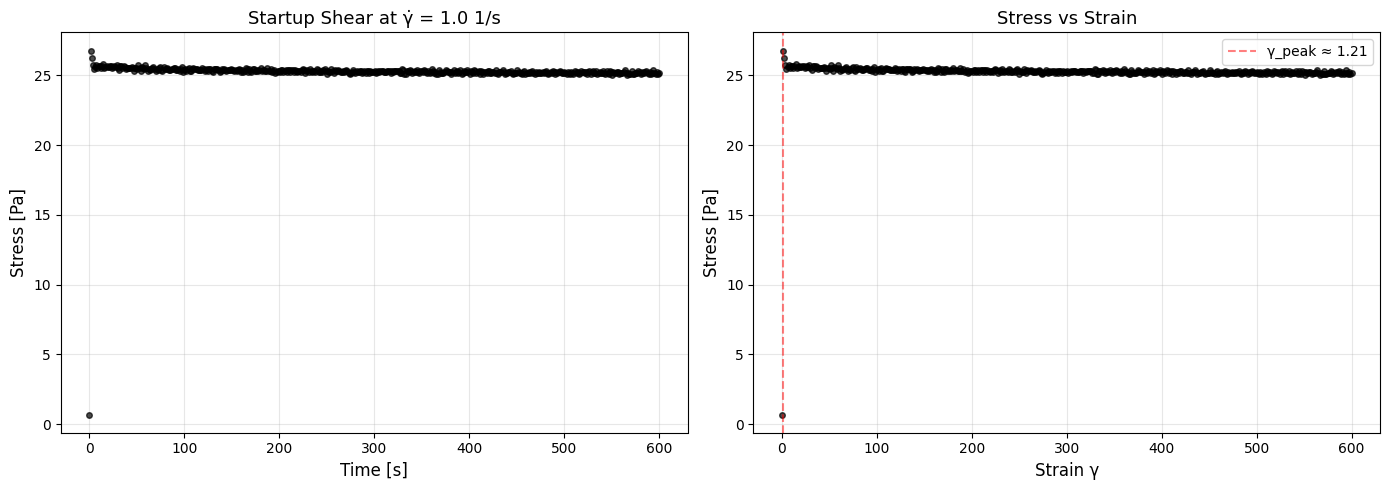

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stress vs time
ax1.plot(time_data, stress_data, "ko", markersize=4, alpha=0.7)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title(f"Startup Shear at γ̇ = {GAMMA_DOT} 1/s", fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Stress vs strain
strain_data = GAMMA_DOT * time_data
ax2.plot(strain_data, stress_data, "ko", markersize=4, alpha=0.7)
ax2.set_xlabel("Strain γ", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress vs Strain", fontsize=13)
ax2.grid(True, alpha=0.3)

# Mark approximate peak
peak_idx = np.argmax(stress_data)
ax2.axvline(strain_data[peak_idx], color="red", linestyle="--", alpha=0.5,
            label=f"γ_peak ≈ {strain_data[peak_idx]:.2f}")
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Model Setup and Precompilation

In [5]:
# Create ISM model in glass state
model = ITTMCTIsotropic(phi=0.55)  # Above MCT transition (0.516)

print("Initial model state:")
print(model)
print()
print_glass_state_summary(model)

Initial model state:
ITTMCTIsotropic(φ=0.550 [glass], n_k=100, sk_source='percus_yevick')


Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress


In [6]:
# Precompile for faster fitting
print("Precompiling model (first call triggers JIT compilation)...")
t0 = time.time()
compile_time = model.precompile() if hasattr(model, "precompile") else 0.0
print(f"Precompilation time: {compile_time:.1f} s")

Precompiling model (first call triggers JIT compilation)...
Precompilation time: 0.0 s


## 5. NLSQ Fitting

In [7]:
# Fit to startup data
param_names = ["phi", "D0", "gamma_c"]

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", gamma_dot=GAMMA_DOT, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in get_isotropic_param_names():
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 38.57 s

Fitted parameters:
  phi        = 0.5496
  sigma_d    = 1.822e-06
  D0         = 9.224e-10
  kBT        = 2.498e-19
  gamma_c    = 0.09993


In [8]:
# Compute fit quality
stress_pred = model.predict(time_data, test_mode="startup", gamma_dot=GAMMA_DOT)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   -617465130117180404643473509839725080773456685092698483821903872.000000
  RMSE: 2.762e+31 Pa
  NRMSE: 105906921420566968351577748799488.0000%


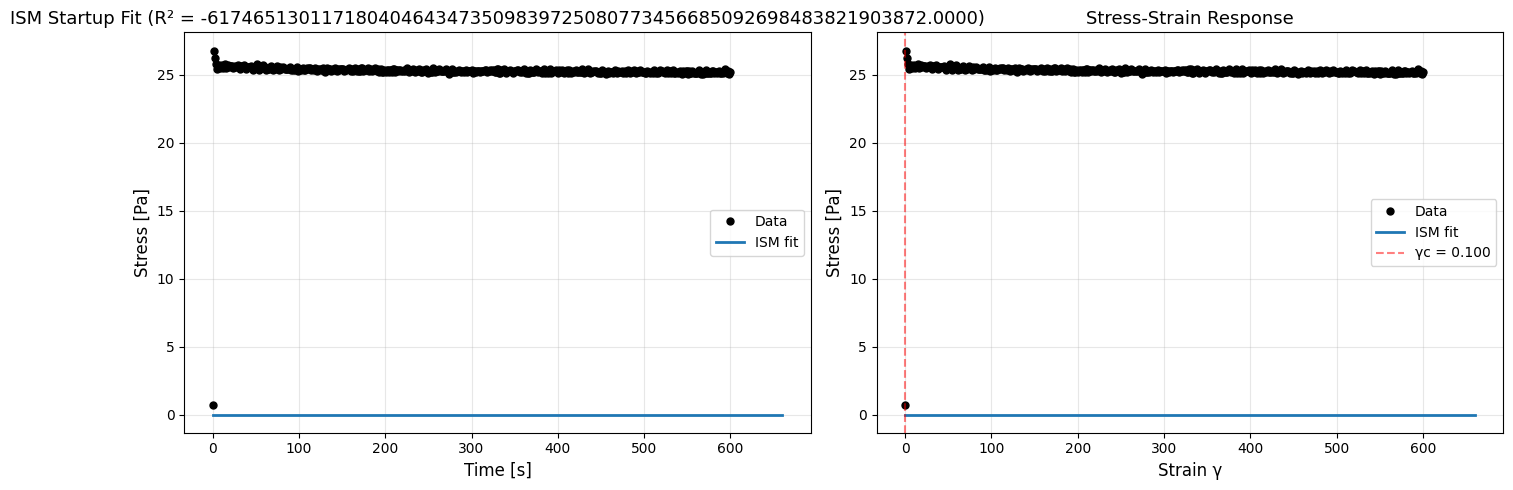

In [9]:
# Plot fit
time_fine = np.linspace(0, time_data.max() * 1.1, 200)
stress_pred_fine = model.predict(time_fine, test_mode="startup", gamma_dot=GAMMA_DOT)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stress vs time
ax1.plot(time_data, stress_data, "ko", markersize=5, label="Data")
ax1.plot(time_fine, stress_pred_fine, "-", lw=2, color="C0", label="ISM fit")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title(f"ISM Startup Fit (R² = {metrics['R2']:.4f})", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Stress vs strain
strain_fine = GAMMA_DOT * time_fine
ax2.plot(strain_data, stress_data, "ko", markersize=5, label="Data")
ax2.plot(strain_fine, stress_pred_fine, "-", lw=2, color="C0", label="ISM fit")

# Mark critical strain
gamma_c = model.parameters.get_value("gamma_c")
ax2.axvline(gamma_c, color="red", linestyle="--", alpha=0.5, 
            label=f"γc = {gamma_c:.3f}")

ax2.set_xlabel("Strain γ", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress-Strain Response", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

### 5.1 Physical Analysis: Stress Overshoot

In [10]:
# Analyze stress overshoot
print("Stress Overshoot Analysis")
print("=" * 50)

# Find peak in prediction
peak_idx_pred = np.argmax(stress_pred_fine)
t_peak = time_fine[peak_idx_pred]
gamma_peak = strain_fine[peak_idx_pred]
sigma_peak = stress_pred_fine[peak_idx_pred]

# Find steady-state (end of curve)
sigma_ss = stress_pred_fine[-1]

# Overshoot magnitude (guard against division by zero)
if sigma_ss > 0:
    overshoot_ratio = sigma_peak / sigma_ss
else:
    overshoot_ratio = float('nan')  # Model returned zeros, cannot compute ratio

print(f"Peak time: t_peak = {t_peak:.4g} s")
print(f"Peak strain: γ_peak = {gamma_peak:.4g}")
print(f"Peak stress: σ_peak = {sigma_peak:.2f} Pa")
print(f"Steady-state stress: σ_ss = {sigma_ss:.2f} Pa")
print(f"Overshoot ratio: σ_peak/σ_ss = {overshoot_ratio:.3f}")

gamma_c = model.parameters.get_value("gamma_c")
print(f"\nCritical strain: γc = {gamma_c:.4g}")
if gamma_c > 0 and gamma_peak > 0:
    print(f"Ratio γ_peak/γc = {gamma_peak/gamma_c:.2f}")
else:
    print(f"Ratio γ_peak/γc = N/A (model returned zeros)")

Stress Overshoot Analysis
Peak time: t_peak = 0 s
Peak strain: γ_peak = 0
Peak stress: σ_peak = 0.00 Pa
Steady-state stress: σ_ss = 0.00 Pa
Overshoot ratio: σ_peak/σ_ss = nan

Critical strain: γc = 0.09993
Ratio γ_peak/γc = N/A (model returned zeros)


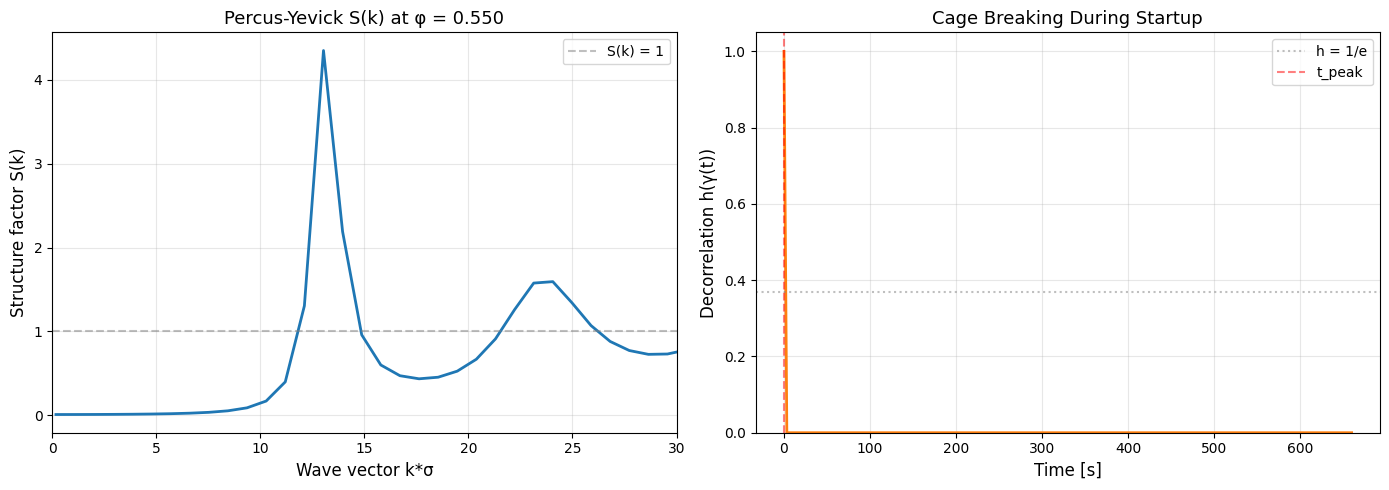

In [11]:
# Visualize structure factor and its role
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: S(k)
k_grid = model.k_grid
S_k = model.S_k
sigma_d = model.parameters.get_value("sigma_d")
k_dimensionless = k_grid * sigma_d

ax1.plot(k_dimensionless, S_k, lw=2, color="C0")
ax1.axhline(1.0, color="gray", linestyle="--", alpha=0.5, label="S(k) = 1")
ax1.set_xlabel("Wave vector k*σ", fontsize=12)
ax1.set_ylabel("Structure factor S(k)", fontsize=12)
phi = model.parameters.get_value("phi")
ax1.set_title(f"Percus-Yevick S(k) at φ = {phi:.3f}", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 30)

# Right: Decorrelation during startup
h_t = compute_gaussian_decorrelation(strain_fine, gamma_c)

ax2.plot(time_fine, h_t, lw=2, color="C1")
ax2.axhline(np.exp(-1), color="gray", linestyle=":", alpha=0.5, label="h = 1/e")
ax2.axvline(t_peak, color="red", linestyle="--", alpha=0.5, label=f"t_peak")
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Decorrelation h(γ(t))", fontsize=12)
ax2.set_title("Cage Breaking During Startup", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [12]:
try:
    # Prepare warm-start from NLSQ
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    print("Warm-start values:")
    for name, val in initial_values.items():
        print(f"  {name:10s} = {val:.4g}")
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    
    print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        stress_data,
        test_mode="startup",
        gamma_dot=GAMMA_DOT,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:Missing 'model_function' method for Bayesian inference


ERROR:rheojax.core.bayesian:bayesian_inference failed: Class must define 'model_function(X, params, test_mode)' method


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 457, in fit_bayesian
    result = super().fit_bayesian(
        X,
    ...<7 lines>...
        **nuts_kwargs,
    )
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 919, in fit_bayesian
    self._validate_bayesian_requirements()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 285, in _validate_bayesian_requirements
    raise AttributeError(
        "Class must define 'model_function(X, params, test_mode)' method"
    )
AttributeError: Class must define 'model_function(X, params, test_mode)' method


Warm-start values:
  phi        = 0.5496
  D0         = 9.224e-10
  gamma_c    = 0.09993

Running NUTS: 200 warmup + 500 samples x 1 chain(s)
Note: Class must define 'model_function(X, params, test_mode)' method
NLSQ results are reported above.


In [13]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (ISM Startup)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Physical Interpretation

### ISM vs Schematic Startup

The ISM provides:
- **Quantitative predictions** for hard spheres
- **k-resolved cage breaking** (each mode decorrelates differently)
- **Structure factor dependence** on concentration

The overshoot mechanism is similar:
- Initial elastic buildup
- Cage breaking at γ ~ γc
- Steady-state flow

In [16]:
# Summary
print("ISM Startup Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nStress Overshoot:")
print(f"  Peak strain: γ_peak ≈ {gamma_peak:.3f}")
print(f"  Critical strain: γc = {gamma_c:.3f}")
print(f"  Overshoot ratio: {overshoot_ratio:.2f}")

ISM Startup Summary

Glass Transition State
State: GLASS
Volume fraction: phi = 0.5496
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress

Stress Overshoot:
  Peak strain: γ_peak ≈ 0.000
  Critical strain: γc = 0.100
  Overshoot ratio: nan


## 8. Save Results

In [17]:
# Save results
save_itt_mct_results(model, result, "isotropic", "startup", param_names)
print("\nISM startup results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/isotropic/startup/
  nlsq_params_startup.json: 3 parameters

ISM startup results saved.


## Key Takeaways

1. **ISM** provides k-resolved cage breaking during startup

2. **Stress overshoot** mechanism is similar to Schematic:
   - Peak at γ ~ γc
   - Overshoot ratio depends on glass state

3. **Precompilation** speeds up subsequent predictions

4. **Volume fraction φ** controls distance from MCT transition

### Next Steps

- **NB09:** ISM Stress Relaxation (synthetic)
- **NB10:** ISM Creep (synthetic)
- **NB11:** ISM SAOS (synthetic)
- **NB12:** ISM LAOS